# What am I gonna be doing?

So in this project I wanted to predict the total number of runs of a cricket game. I want to look at both numeric and non-numeric preditctors so we have 2 sections of the dummies and the numbers. This project is a long one, also sometimes you may get 4 good written sentences for an explanation, then a 1 senetence explanation that is bland. In the interest of time I put more effort towards explaining the things I found interesting and not redundant. 

# Context

So I'm assuming that my audience isn't familiar with cricket at all so I am going to explain some basic stuff through out the project. Right now all you need to know is this, in a game of cricket the goal is to get more runs that the opponent, simple. So, I am simple trying to model that with a variety of factors.

# Imports

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns
import graphviz as gr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Wrangling


In [3]:
#This csv contains data regarding each individual ball bowled in a game 
deliveries = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_8/deliveries.csv")

#This csv contains data regarding each match in a season
matches = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_8/matches.csv")

In [4]:
#Here I'm aggregating all the runs in a match and adding that data into matches df
total_runs = deliveries.groupby('match_id')['total_runs'].sum()
matches = matches.merge(total_runs, left_on='id', right_index=True)

matches

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,total_runs
0,501198,2011,Chennai,4/8/2011,League,S Anirudha,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Kolkata Knight Riders,Chennai Super Kings,...,Chennai Super Kings,runs,2.0,154.0,20.0,N,NaN,BR Doctrove,PR Reiffel,304
1,501199,2011,Hyderabad,4/9/2011,League,SK Trivedi,"Rajiv Gandhi International Stadium, Uppal",Deccan Chargers,Rajasthan Royals,Rajasthan Royals,...,Rajasthan Royals,wickets,8.0,138.0,20.0,N,NaN,RE Koertzen,SK Tarapore,278
2,501200,2011,Kochi,4/9/2011,League,AB de Villiers,Nehru Stadium,Kochi Tuskers Kerala,Royal Challengers Bangalore,Kochi Tuskers Kerala,...,Royal Challengers Bangalore,wickets,6.0,162.0,20.0,N,NaN,HDPK Dharmasena,K Hariharan,323
3,501201,2011,Delhi,4/10/2011,League,SL Malinga,Feroz Shah Kotla,Delhi Daredevils,Mumbai Indians,Delhi Daredevils,...,Mumbai Indians,wickets,8.0,96.0,20.0,N,NaN,AM Saheba,RB Tiffin,194
4,501202,2011,Mumbai,4/10/2011,League,SB Wagh,Dr DY Patil Sports Academy,Pune Warriors,Kings XI Punjab,Kings XI Punjab,...,Pune Warriors,wickets,7.0,113.0,20.0,N,NaN,BR Doctrove,PR Reiffel,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,1426307,2024,Hyderabad,5/19/2024,League,Abhishek Sharma,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,Sunrisers Hyderabad,Punjab Kings,...,Sunrisers Hyderabad,wickets,4.0,215.0,20.0,N,NaN,Nitin Menon,VK Sharma,429
916,1426309,2024,Ahmedabad,5/21/2024,Qualifier 1,MA Starc,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,...,Kolkata Knight Riders,wickets,8.0,160.0,20.0,N,NaN,AK Chaudhary,R Pandit,323
917,1426310,2024,Ahmedabad,5/22/2024,Eliminator,R Ashwin,"Narendra Modi Stadium, Ahmedabad",Royal Challengers Bengaluru,Rajasthan Royals,Rajasthan Royals,...,Rajasthan Royals,wickets,4.0,173.0,20.0,N,NaN,KN Ananthapadmanabhan,MV Saidharshan Kumar,346
918,1426311,2024,Chennai,5/24/2024,Qualifier 2,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,...,Sunrisers Hyderabad,runs,36.0,176.0,20.0,N,NaN,Nitin Menon,VK Sharma,314


# Data Exploration

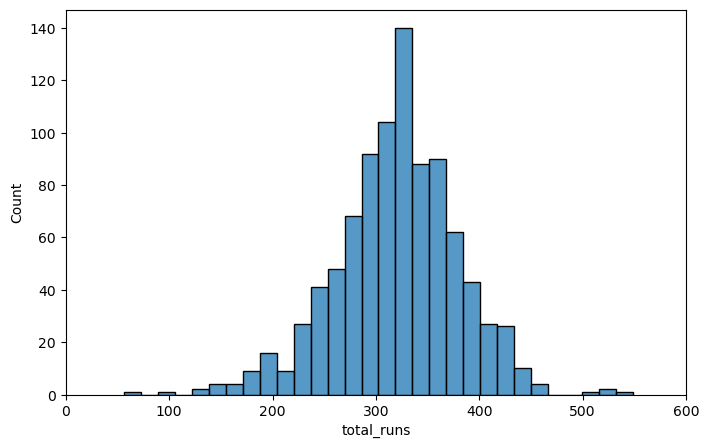

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(data=matches, x="total_runs", bins=30)
plt.xlim(0, 600)
plt.show()

Total match runs (sum of both innings) is a positive continuous outcome. The distribution of total runs is roughly bell shaped around 320 runs, with a long tail on both ends for very low or very high scoring games. Most matches are around 250–400 runs, with a few extreme outliers on both sides.

I think initally looking at this histrogram a normal likelihood could work.

# Casual Diagram

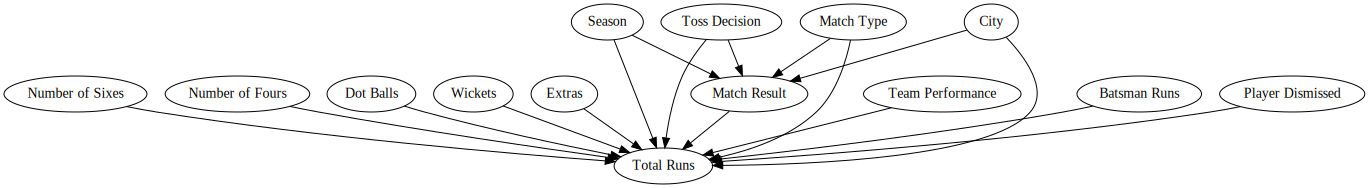

In [114]:
import graphviz as gr
from graphviz import Source

dot = gr.Digraph(format='png')

dot.node('total_runs', 'Total Runs')
dot.node('sixes', 'Number of Sixes')
dot.node('fours', 'Number of Fours')
dot.node('dot_balls', 'Dot Balls')
dot.node('wickets', 'Wickets')
dot.node('extras', 'Extras')
dot.node('season', 'Season')
dot.node('toss_decision', 'Toss Decision')
dot.node('match_type', 'Match Type')
dot.node('city', 'City')
dot.node('team', 'Team Performance')
dot.node('result', 'Match Result')
dot.node('batting_performance', 'Batsman Runs')

dot.node('player_dismissed', 'Player Dismissed')

dot.edge('sixes', 'total_runs')
dot.edge('fours', 'total_runs')
dot.edge('dot_balls', 'total_runs')
dot.edge('wickets', 'total_runs')
dot.edge('extras', 'total_runs')
dot.edge('season', 'total_runs')
dot.edge('toss_decision', 'total_runs')
dot.edge('match_type', 'total_runs')
dot.edge('city', 'total_runs')
dot.edge('team', 'total_runs')
dot.edge('result', 'total_runs')
dot.edge('batting_performance', 'total_runs')

dot.edge('match_type', 'result')
dot.edge('city', 'result')
dot.edge('season', 'result')
dot.edge('toss_decision', 'result')

dot.edge('player_dismissed', 'total_runs')

Source(dot.source)


# The Dummies

## Model 1

For this model I'm going to initally be using more generic factors that I think will have an effect on the likelihood these following predictors, city, season, toss_decision, type of match. Over the years, IPL scores have generally increased as the original methodology for cricket is to be conservative and try not to get out in favor of trying to go for more runs. As time went on teams realized this is dumb for T20(a version of cricket that turns a full day game into 3-4 hours by reducing the number of balls played from 600 to 240), some stadiums consistently produce higher totals. finals or elimination matches might see more cautious play so it would make run totals lower. The final variable of toss_decision I don't actullay know how much of an effect it has, it isn't that strong in my head, but it's a pretty interesting variable to me so it would be cool to see what effect it has.

In [32]:
#Here I am taking any time there is an empty entry in city and replacing that an unknown city label
matches['city'] = matches['city'].fillna('UnknownCity')

#this just isolates the season numerically as the 2020 season was split across 2020 and 2021 so it has a / i need to remove.
matches['season'] = matches['season'].apply(lambda x: int(x.split('/')[0]) if isinstance(x, str) else x)

In [33]:
X = pd.get_dummies(matches[['season', 'city', 'toss_decision', 'match_type']], columns=['city', 'match_type'], drop_first=True)
X['toss_decision'] = X['toss_decision'].map({'bat':0, 'field':1})
Y = matches['total_runs'].values

In [34]:
#what get dummies does is it turns a categorical into a boolean for an entry in that column, so I can essentially isolate cities,match types,seasons 
X

,season,toss_decision,city_Ahmedabad,city_Bangalore,city_Bengaluru,city_Chandigarh,city_Chennai,city_Cuttack,city_Delhi,city_Dharamsala,...,city_Rajkot,city_Ranchi,city_Sharjah,city_UnknownCity,city_Visakhapatnam,match_type_Eliminator,match_type_Final,match_type_League,match_type_Qualifier 1,match_type_Qualifier 2
0,2011,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,2011,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2011,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2011,0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,2011,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2024,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
916,2024,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
917,2024,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
918,2024,1,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [8]:
with pm.Model() as model1:
    σ = pm.HalfNormal('σ', sigma=20)            
    μ_ = pmb.BART('μ_', X.values, Y, m=50) 
    μ = pm.Deterministic("μ", μ_)           
    obs = pm.Normal('obs', mu=μ, sigma=σ, observed=Y)   
    idata1 = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.


Sampling: [obs]


Output()

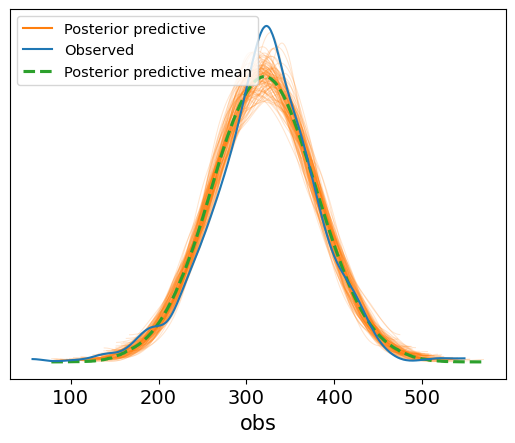

In [9]:
pm.sample_posterior_predictive(idata1,model1, extend_inferencedata=True)
ax = az.plot_ppc(idata1, num_pp_samples=100, colors=["C1", "C0", "C2"])

The initial dummy-variable model captures the general trend, but it struggles at the extremes. In particular, the model underestimates the highest match totals (its predicted peak never reaches the observed peak values) and overestimates some of the lower totals. The distribution is too conservative, it misses the actual spikes in runs and predicts too high on the low end. To address this, we could try using a more flexible error distribution and consider adding more predictors to help the model better account for those extreme cases.

<Axes: ylabel='R²'>

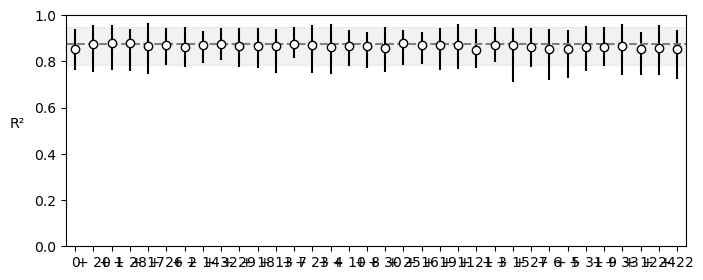

In [ ]:
X_numeric = X.values.astype('float64')
vi1 = pmb.compute_variable_importance(idata1, μ_, X_numeric)
pmb.plot_variable_importance(vi1)
#the numbers represent the column they're from

In [11]:
X.columns

Index(['season', 'toss_decision', 'city_Ahmedabad', 'city_Bangalore',
       'city_Bengaluru', 'city_Chandigarh', 'city_Chennai', 'city_Cuttack',
       'city_Delhi', 'city_Dharamsala', 'city_Dubai', 'city_Guwahati',
       'city_Hyderabad', 'city_Indore', 'city_Jaipur', 'city_Kanpur',
       'city_Kochi', 'city_Kolkata', 'city_Lucknow', 'city_Mohali',
       'city_Mumbai', 'city_Navi Mumbai', 'city_Pune', 'city_Raipur',
       'city_Rajkot', 'city_Ranchi', 'city_Sharjah', 'city_UnknownCity',
       'city_Visakhapatnam', 'match_type_Eliminator', 'match_type_Final',
       'match_type_League', 'match_type_Qualifier 1',
       'match_type_Qualifier 2'],
      dtype='object')

The variable importance show that season contributes the most to the model’s R². In fact, season accounts for the largest drop in R² when left out, whereas the city and match_type dummy variables each contribute very little. This suggests that the year of the match has a large impact on total runs (maybe showing a idealistic difference in cricket theory over seasons or the decision to allow imports), while the stadium or match format does not change the predicted total. The dummy of cities and match types likely spreads out their influence, making each individual city or match format look almost useless in comparison to season’s effect.

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\pymc_bart\utils.py:516: UserWarning: The grid is smaller than the number of available variables to plot.
                Automatically adjusting the grid size.
  warnings.warn(


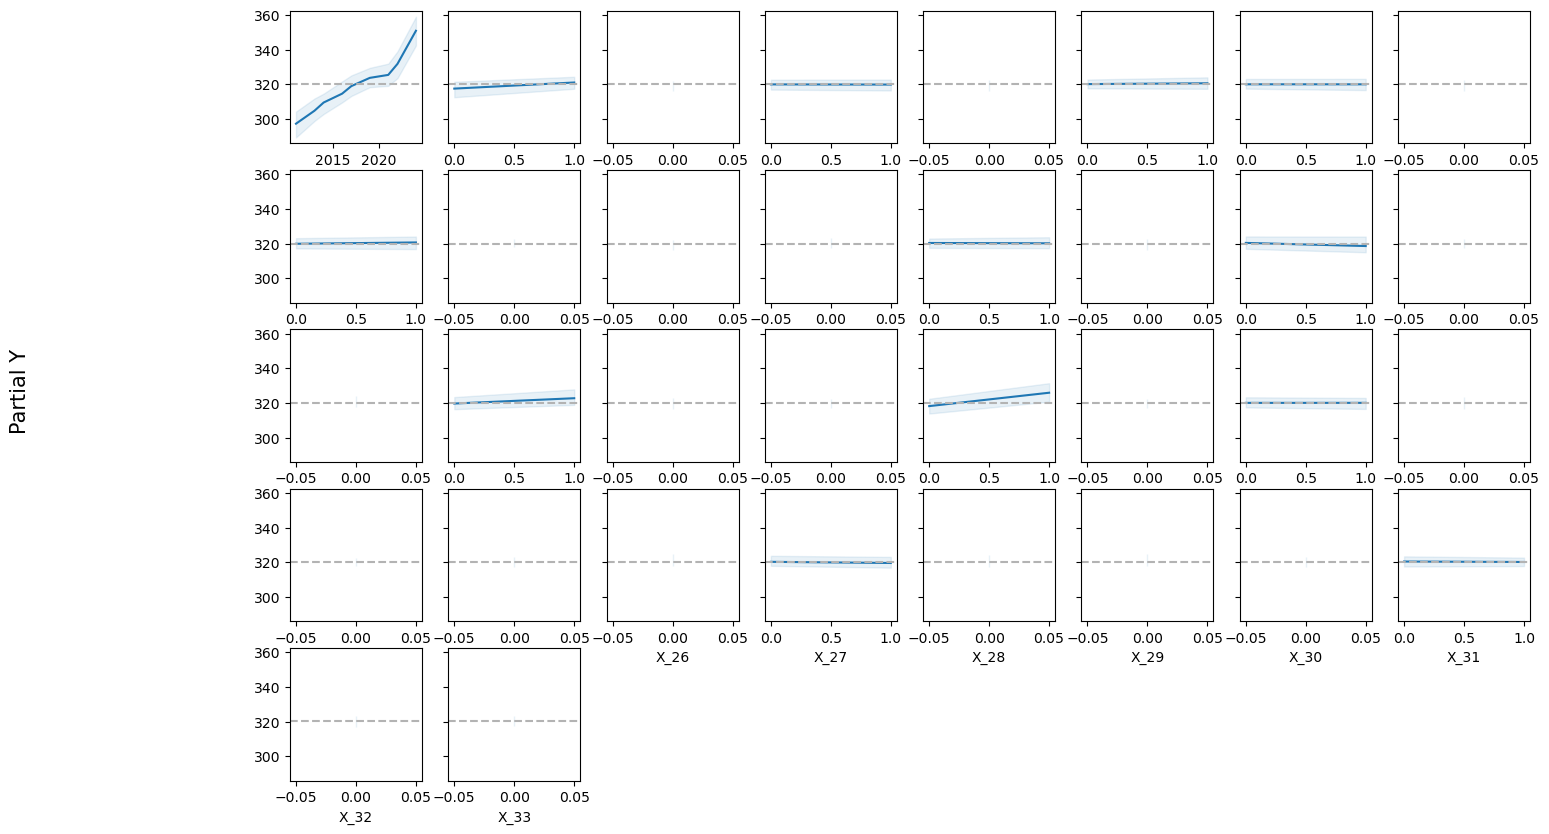

In [12]:
pmb.plot_pdp(μ_, X_numeric, Y, smooth=False, grid=(4,8), figsize=(16, 10))
plt.show()

In [13]:
#This is the order in which the pdp graphs appear.
X.columns

Index(['season', 'toss_decision', 'city_Ahmedabad', 'city_Bangalore',
       'city_Bengaluru', 'city_Chandigarh', 'city_Chennai', 'city_Cuttack',
       'city_Delhi', 'city_Dharamsala', 'city_Dubai', 'city_Guwahati',
       'city_Hyderabad', 'city_Indore', 'city_Jaipur', 'city_Kanpur',
       'city_Kochi', 'city_Kolkata', 'city_Lucknow', 'city_Mohali',
       'city_Mumbai', 'city_Navi Mumbai', 'city_Pune', 'city_Raipur',
       'city_Rajkot', 'city_Ranchi', 'city_Sharjah', 'city_UnknownCity',
       'city_Visakhapatnam', 'match_type_Eliminator', 'match_type_Final',
       'match_type_League', 'match_type_Qualifier 1',
       'match_type_Qualifier 2'],
      dtype='object')

In our partial dependence plots, some predictors show changes while others remain almost flat. For example, the season variable shows a clear upward trend over time, meaning that as the years go by, the expected total runs steadily increase. This is easy to see because “season” is a continuous number that gradually changes. On the other hand, many of the city and match-type predictors are dummy variables, which only have two values either 0 or 1. The plot for these variables only compares what happens when the value is 0 versus when it is 1. If the change in the model’s prediction between these two cases is very small, the line in the plot will look almost flat. In some cases, there might also be few examples for one of the values, so the model cannot clearly show a difference resulting in no visible line. Also, looking at toss decision, if the team who won the toss chose to field first there seems to be an every so slightly higher total runs. Overall when looking at the cities there isn't nearly as big as a difference as I thought there would be, Mumbai is a notable exception and after some research I found out that its location allows for wind from the arabian sea to come towards the batter which could explain its increase, and the same thing for match type. To be honest from this plot I can basically say that Season is something I need to keep using while the other predicators are expendable. 








## Model 2

Based on Model 1 results, the clear next step to me is to include team strength factors. Many outliers were associated with specific teams like matches involving Royal Challengers Bangalore (RCB) often saw very high totals, whereas matches with teams like Kochi Tuskers Kerala or Pune Warriors had lower totals. I think I willl stick with the Normal likelihood though. Also I want to drop the match type column because I didn't see it have much effect in the plots above.

In [ ]:
#This is how I'm getting the dummies for the teams 
teams = matches['team1'].unique().tolist()
for team in teams:
    matches[f'team_{team}'] = ((matches['team1'] == team) | (matches['team2'] == team)).astype(int)
matches.drop(columns=['team_Chennai Super Kings'], inplace=True)

#Again the city dummies
city = pd.get_dummies(matches['city'], prefix='city', drop_first=True)

vars = X[['season', 'toss_decision']]

team_cols = [col for col in matches.columns if col.startswith('team_')]

#concatenate team dummies and city dummies and season and toss decision into one df
X2 = pd.concat([X.reset_index(drop=True), matches[team_cols].reset_index(drop=True)], axis=1)

Y = matches['total_runs'].values

In [15]:
X2

,season,toss_decision,city_Ahmedabad,city_Bangalore,city_Bengaluru,city_Chandigarh,city_Chennai,city_Cuttack,city_Delhi,city_Dharamsala,...,team_Mumbai Indians,team_Sunrisers Hyderabad,team_Gujarat Lions,team_Rising Pune Supergiants,team_Rising Pune Supergiant,team_Delhi Capitals,team_Punjab Kings,team_Lucknow Super Giants,team_Gujarat Titans,team_Royal Challengers Bengaluru
0,2011,0,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,2011,1,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,2011,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,2011,0,False,False,False,False,False,False,True,False,...,1,0,0,0,0,0,0,0,0,0
4,2011,0,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,2024,0,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,1,0,0,0
916,2024,0,True,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0
917,2024,1,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,1
918,2024,1,False,False,False,False,True,False,False,False,...,0,1,0,0,0,0,0,0,0,0


In [16]:
with pm.Model() as model2:
    μ_ = pmb.BART('μ_', X2.values, Y, m=50) 
    μ = pm.Deterministic("μ", μ_)         
    σ = pm.HalfNormal('σ', sigma=20)                
    obs = pm.Normal('obs', mu=μ, sigma=σ, observed=Y) 
    idata2 = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ_]
>NUTS: [σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


Sampling: [obs]


Output()

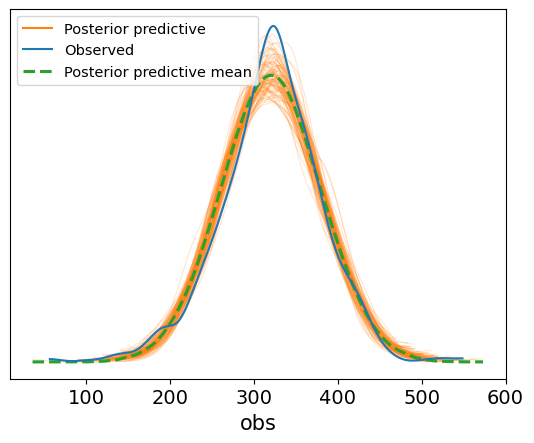

In [17]:
pm.sample_posterior_predictive(idata2,model2, extend_inferencedata=True)
ax = az.plot_ppc(idata2, num_pp_samples=100, colors=["C1", "C0", "C2"])

wow, this PPC looks really similar to our previous one. the new predictor of teams didn't add much of a difference, but I want to investigate further the effect of teams so lets create the VI, PDP

<Axes: ylabel='R²'>

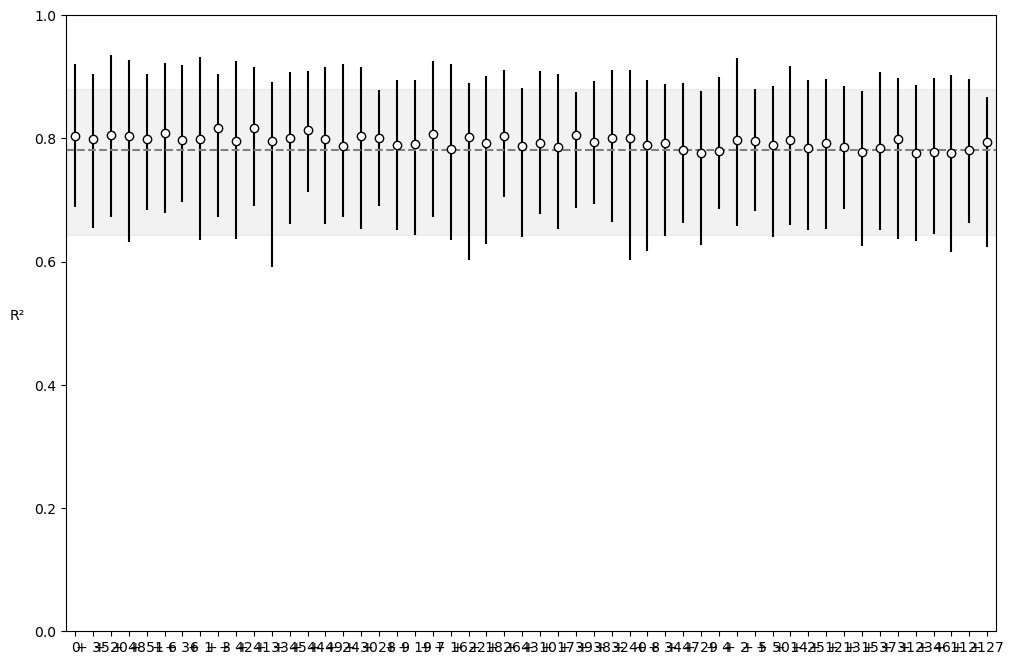

In [18]:
X2_numeric = X2.values.astype('float64')
vi2 = pmb.compute_variable_importance(idata2, μ_, X2_numeric)
fig, ax = plt.subplots(figsize=(12, 8))
pmb.plot_variable_importance(vi2, ax=ax) 
#again the columns are to numbers.

In [19]:
X2.columns

Index(['season', 'toss_decision', 'city_Ahmedabad', 'city_Bangalore',
       'city_Bengaluru', 'city_Chandigarh', 'city_Chennai', 'city_Cuttack',
       'city_Delhi', 'city_Dharamsala', 'city_Dubai', 'city_Guwahati',
       'city_Hyderabad', 'city_Indore', 'city_Jaipur', 'city_Kanpur',
       'city_Kochi', 'city_Kolkata', 'city_Lucknow', 'city_Mohali',
       'city_Mumbai', 'city_Navi Mumbai', 'city_Pune', 'city_Raipur',
       'city_Rajkot', 'city_Ranchi', 'city_Sharjah', 'city_UnknownCity',
       'city_Visakhapatnam', 'match_type_Eliminator', 'match_type_Final',
       'match_type_League', 'match_type_Qualifier 1', 'match_type_Qualifier 2',
       'team_Deccan Chargers', 'team_Kochi Tuskers Kerala',
       'team_Delhi Daredevils', 'team_Pune Warriors',
       'team_Kolkata Knight Riders', 'team_Rajasthan Royals',
       'team_Royal Challengers Bangalore', 'team_Kings XI Punjab',
       'team_Mumbai Indians', 'team_Sunrisers Hyderabad', 'team_Gujarat Lions',
       'team_Rising Pune 

In Model 1, the vi plot showed that the predictor contributing most to total match runs was seasons. In Model 2, after adding team predictors into model season still remains as very important. The Model 2 VI plot shows that adding the team predictors didn't really do much, infact some of them reduced the R^2 of the model. Toss decision and match type remain  weak predictors compared to season along with the newly added team variables. Again the variation is ever so slight between variables which could be due to us using dummy variables. The PDP will provide a lot more understanding and I was planning on trying out an ICE plot, but that took over 2 hours to run and still didn't compile so I gave up. 









c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\pymc_bart\utils.py:516: UserWarning: The grid is smaller than the number of available variables to plot.
                Automatically adjusting the grid size.
  warnings.warn(


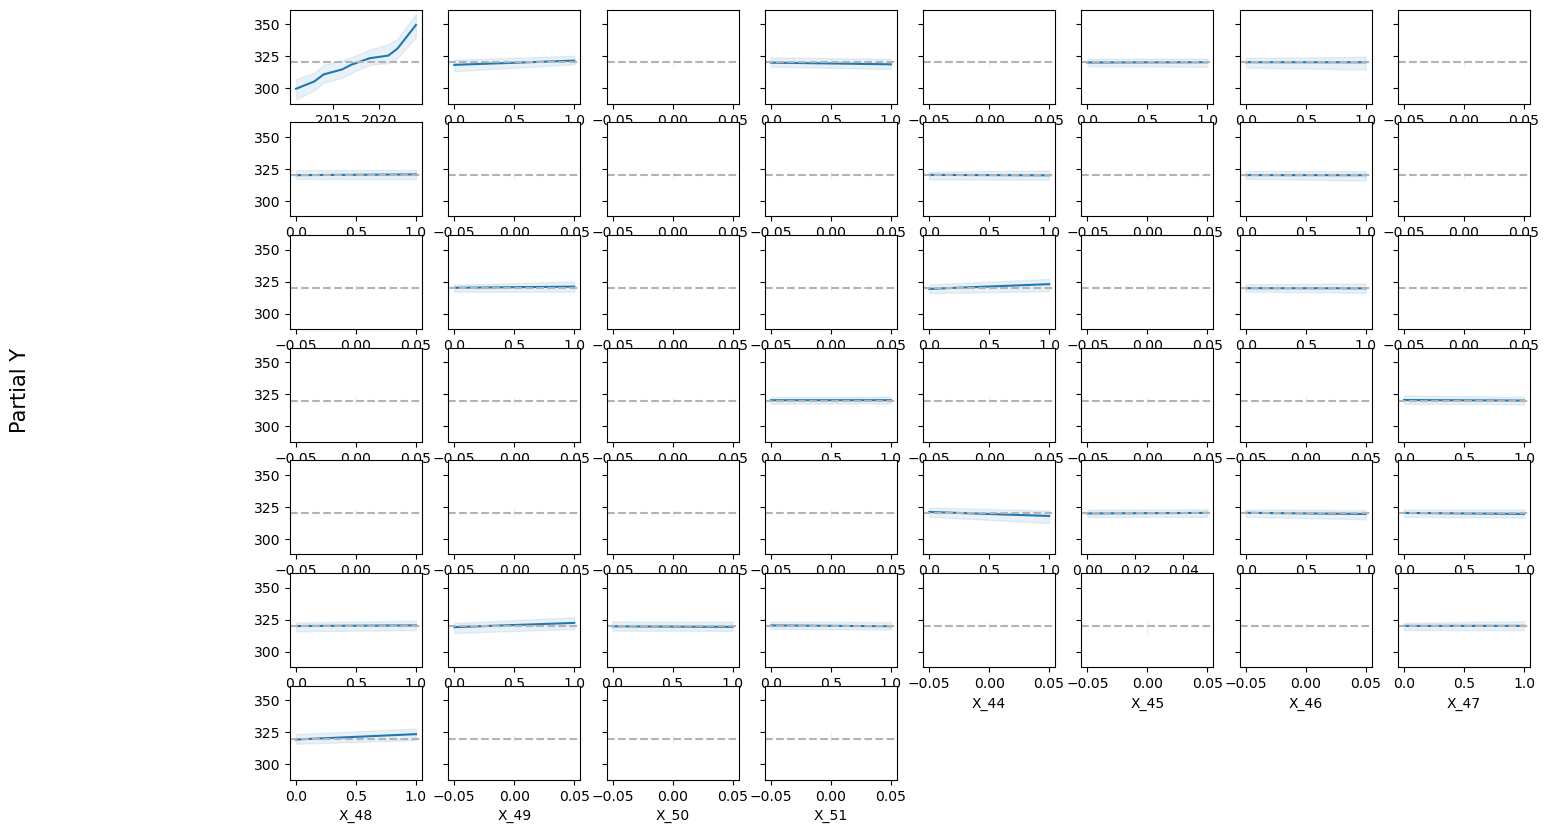

In [20]:
pmb.plot_pdp(μ_, X2_numeric, Y, smooth=False, grid=(4,8), figsize=(16, 10))
plt.show()

In [21]:
X2.columns

Index(['season', 'toss_decision', 'city_Ahmedabad', 'city_Bangalore',
       'city_Bengaluru', 'city_Chandigarh', 'city_Chennai', 'city_Cuttack',
       'city_Delhi', 'city_Dharamsala', 'city_Dubai', 'city_Guwahati',
       'city_Hyderabad', 'city_Indore', 'city_Jaipur', 'city_Kanpur',
       'city_Kochi', 'city_Kolkata', 'city_Lucknow', 'city_Mohali',
       'city_Mumbai', 'city_Navi Mumbai', 'city_Pune', 'city_Raipur',
       'city_Rajkot', 'city_Ranchi', 'city_Sharjah', 'city_UnknownCity',
       'city_Visakhapatnam', 'match_type_Eliminator', 'match_type_Final',
       'match_type_League', 'match_type_Qualifier 1', 'match_type_Qualifier 2',
       'team_Deccan Chargers', 'team_Kochi Tuskers Kerala',
       'team_Delhi Daredevils', 'team_Pune Warriors',
       'team_Kolkata Knight Riders', 'team_Rajasthan Royals',
       'team_Royal Challengers Bangalore', 'team_Kings XI Punjab',
       'team_Mumbai Indians', 'team_Sunrisers Hyderabad', 'team_Gujarat Lions',
       'team_Rising Pune 

We can see from this PDP that adding the teams didn't really have much effect as the overwhelming majority of them don't even have a visible line and if they do the difference is super small. This is really suprising to me because I thought that teams would have a large effect. I think this could just be the data saying that the difference between teams isn't that big, or it could be something to do with me averaging across every season which could reduce that variation I think would happen. I am not going to create an ice plot for this portion of the project because of how many variables I have with dummies, later on in the numeric side we look at the ICE plots so don't worry.

So from this I can pretty much say seasons is the only predictor that does much, while the other ones don't have much effect either due to poor relation, or because of redundancy by trying out that dummies function. I want to try out a third model using a different likelihood, then shift my focus away from these non-numeric predictors that I found interesting, to more hard statistics based ones.







In [24]:
posterior_mean = idata2.posterior["μ"]

μ_hdi = az.hdi(ary=idata2, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata2, group="posterior_predictive", var_names=["obs"]
).T

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


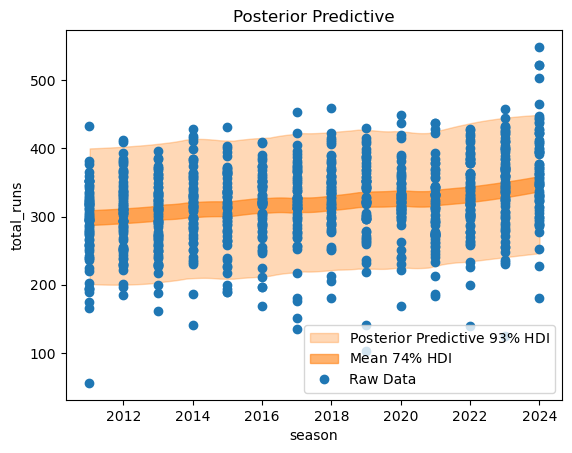

In [25]:
idx = np.argsort(X2_numeric[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X2_numeric[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X2_numeric[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(X2["season"], matches["total_runs"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="season",
    ylabel="total_runs",
);

After determining that seasons is the most important predictor, I did this PPC graph with the observed and as we can se there is a slight overal upward trend that my model is reperesenting pretty accuratly. The right tail is heavier than expected so maybe changing distributions to one that take takes that into account could be better. 

## Model 3

Now, based on all the models so far I can gather that either it is really hard to represent these non-numeric variables in a BART and will not give me anything meaningful. OR all of those factors that I thought had a large effect really don't when looking at IPL data from a historical sense, maybe if I isolated a season it would have a more pronounced effect. Now I want to try to see what it would look like changing my likelihood, but also only using the strongest predictor of season.

In [34]:
X3 = X2[['season']]

Y = matches['total_runs'].values

In [28]:
X3

,season
0,2011
1,2011
2,2011
3,2011
4,2011
...,...
915,2024
916,2024
917,2024
918,2024


In [29]:
with pm.Model() as model3:
    μ_ = pmb.BART('μ_', X3.values, Y, m=100) 
    μ = pm.Deterministic("μ", μ_)        
    ν = pm.Exponential('ν', 1.0)                  
    σ = pm.HalfNormal('σ', sigma=20)
    obs = pm.StudentT('obs', mu=μ, sigma=σ, nu=ν, observed=Y)
    idata3 = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ_]
>NUTS: [ν, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 146 seconds.


Sampling: [obs]


Output()

(0.0, 600.0)

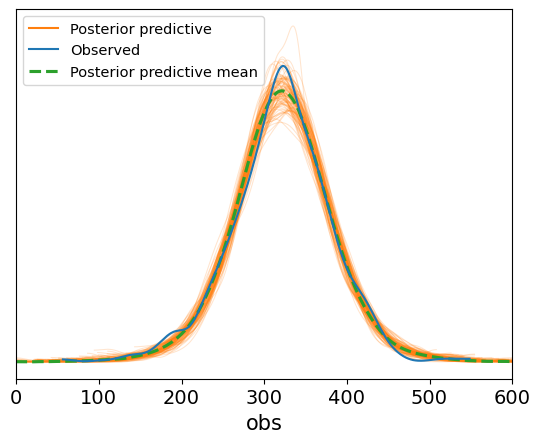

In [30]:
pm.sample_posterior_predictive(idata3,model3, extend_inferencedata=True)
ax = az.plot_ppc(idata3, num_pp_samples=100, colors=["C1", "C0", "C2"])
ax.set_xlim(0, 600)

In [31]:
posterior_mean = idata3.posterior["μ"]

μ_hdi = az.hdi(ary=idata3, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata3, group="posterior_predictive", var_names=["obs"]
).T

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


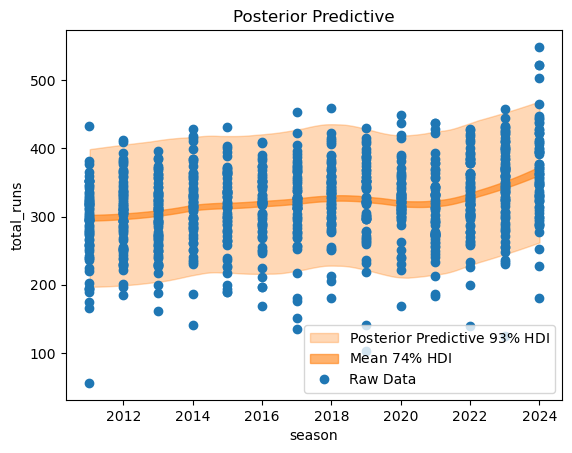

In [35]:
X3_numeric = X3.values

idx = np.argsort(X3_numeric[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X3_numeric[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X3_numeric[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(X3["season"], matches["total_runs"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="season",
    ylabel="total_runs",
);

So this PPC looks even better than the other ones, the peak matches up slightly better which I think goes to show just how strong seasons was, but also how this new likelihood is doing a better job. In the PPC with the observered there doesn't seem to be much difference so, I think we can conclude that season was the most important predictor. Now we just covered pretty much all of the non-numeric stuff I wanted to explore in this data set.

In these dummy models, season emerged as the only important factor, maybe showing an overall rise in scoring over the IPL years. The other categorical factors of toss decision, match city, and match type turned out to have minimal effects on total runs. In essence, the variables we tested (season, city, toss decision, match type) do not individually explain much variation in a match’s runs. The model that relied on these dummy variables ended up mostly capturing a year-to-year scoring trend (via the season variable), while the rest of the dummy inputs added very little improvement. This show that non-numerical/statistic based factors provide little help in predicting total runs.

To conclude this section, I think experimenting with the idea of using non-numeric values in a bart model while interesting, I don't know how much value it provided. Basically, I know that the IPL has evolved over time as seen through seasons. All of the other factors were done through using pd.dummies which was an interesting method I found. I believe that I can conclude that either the way the dummies work results in the plots all being flat which could be the problem as using a dummy will give a small amount of trues out of the 914 entires, or those variables I had just don't effect total runs as much as i thought when looking at the average for them as to be fair it is unheard of for a team to realy be bad for a long time in the IPL. Most suprising of which to me was the match types not having as much as an effect as I thought, which could again be attributed to the nature of dummies. Now honestly this portion of the project took a lot longer that I'd like to admit, but now lets move on to the other part where we are looking at the numbers.  

# The Numbers

## Model 1

I think I probably manipulated the data directly in all the stuff above, so I'm just going to recall the csv's from github and do my data manipulation 

In [42]:
#This csv contains data regarding each individual ball bowled in a game 
deliveries = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_8/deliveries.csv")

#This csv contains data regarding each match in a season
matches = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_8/matches.csv")

fours   = deliveries.groupby('match_id')['batsman_runs'].apply(lambda x: (x == 4).sum())
sixes   = deliveries.groupby('match_id')['batsman_runs'].apply(lambda x: (x == 6).sum())
dot_balls = deliveries.groupby('match_id')['total_runs'].apply(lambda x: (x == 0).sum())    
wickets = deliveries.groupby('match_id')['player_dismissed'].count()
extras  = deliveries.groupby('match_id')['extra_runs'].sum()
total_runs = deliveries.groupby('match_id')['total_runs'].sum()

matches = matches.merge(fours.rename('fours'), left_on='id', right_index=True)
matches = matches.merge(sixes.rename('sixes'), left_on='id', right_index=True)
matches = matches.merge(dot_balls.rename('dot_balls'), left_on='id', right_index=True)
matches = matches.merge(wickets.rename('wickets'), left_on='id', right_index=True)
matches = matches.merge(extras.rename('extras'), left_on='id', right_index=True)
matches = matches.merge(total_runs, left_on='id', right_index=True)

In [43]:
matches

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,...,super_over,method,umpire1,umpire2,fours,sixes,dot_balls,wickets,extras,total_runs
0,501198,2011,Chennai,4/8/2011,League,S Anirudha,"MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Kolkata Knight Riders,Chennai Super Kings,...,N,NaN,BR Doctrove,PR Reiffel,28,7,75,11,11,304
1,501199,2011,Hyderabad,4/9/2011,League,SK Trivedi,"Rajiv Gandhi International Stadium, Uppal",Deccan Chargers,Rajasthan Royals,Rajasthan Royals,...,N,NaN,RE Koertzen,SK Tarapore,25,8,95,10,9,278
2,501200,2011,Kochi,4/9/2011,League,AB de Villiers,Nehru Stadium,Kochi Tuskers Kerala,Royal Challengers Bangalore,Kochi Tuskers Kerala,...,N,NaN,HDPK Dharmasena,K Hariharan,25,12,80,9,24,323
3,501201,2011,Delhi,4/10/2011,League,SL Malinga,Feroz Shah Kotla,Delhi Daredevils,Mumbai Indians,Delhi Daredevils,...,N,NaN,AM Saheba,RB Tiffin,17,3,98,12,15,194
4,501202,2011,Mumbai,4/10/2011,League,SB Wagh,Dr DY Patil Sports Academy,Pune Warriors,Kings XI Punjab,Kings XI Punjab,...,N,NaN,BR Doctrove,PR Reiffel,26,5,100,11,14,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,1426307,2024,Hyderabad,5/19/2024,League,Abhishek Sharma,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Punjab Kings,Sunrisers Hyderabad,Punjab Kings,...,N,NaN,Nitin Menon,VK Sharma,31,26,64,11,27,429
916,1426309,2024,Ahmedabad,5/21/2024,Qualifier 1,MA Starc,"Narendra Modi Stadium, Ahmedabad",Sunrisers Hyderabad,Kolkata Knight Riders,Sunrisers Hyderabad,...,N,NaN,AK Chaudhary,R Pandit,29,16,70,12,18,323
917,1426310,2024,Ahmedabad,5/22/2024,Eliminator,R Ashwin,"Narendra Modi Stadium, Ahmedabad",Royal Challengers Bengaluru,Rajasthan Royals,Rajasthan Royals,...,N,NaN,KN Ananthapadmanabhan,MV Saidharshan Kumar,33,13,71,14,10,346
918,1426311,2024,Chennai,5/24/2024,Qualifier 2,Shahbaz Ahmed,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,...,N,NaN,Nitin Menon,VK Sharma,24,14,94,16,13,314


In [44]:
X = matches[['fours','sixes','dot_balls','wickets','extras']]
Y = matches['total_runs'].values

For this one we are going to be using the predictors of fours, sixes, dot balls, wickets, and extras. In cricket there are 4 main ways to score runs. After you hit the ball, if you run from stump to stump (22 yards) then you get 1 run, you try to run as many times from stump to stump until the opposing team throws the ball at the wicket to get you out (like base ball and bases pretty much). There is a boundary set up from the place where the batter hit in the shape of an oval. The furthest distance is 90 yards, and the shortest is 65 yards, if the batter hits a ball and it hits the boundary they get 4 runs. If they hit it over the boundary they get 6 runs. The final way isn't really a unique way but more like a different method, if the bowler throws a ball thats too wide, or has a different foul while throwing that ball becomes a free ball and the batting team get an extra ball as well. This is called extras. Dot balls are balls where no runs are scored. And wickets is the amount of times a batsman gets out. 

In [45]:
X

,fours,sixes,dot_balls,wickets,extras
0,28,7,75,11,11
1,25,8,95,10,9
2,25,12,80,9,24
3,17,3,98,12,15
4,26,5,100,11,14
...,...,...,...,...,...
915,31,26,64,11,27
916,29,16,70,12,18
917,33,13,71,14,10
918,24,14,94,16,13


In [9]:
with pm.Model() as modelN1:
    σ = pm.HalfNormal('σ', 10)
    μ_ = pmb.BART('μ_', X.values, Y, m=50)    
    μ  = pm.Deterministic('μ', μ_)             
    obs = pm.Normal('obs', mu=μ, sigma=σ, observed=Y)
    idataN1 = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


Sampling: [obs]


Output()

(0.0, 600.0)

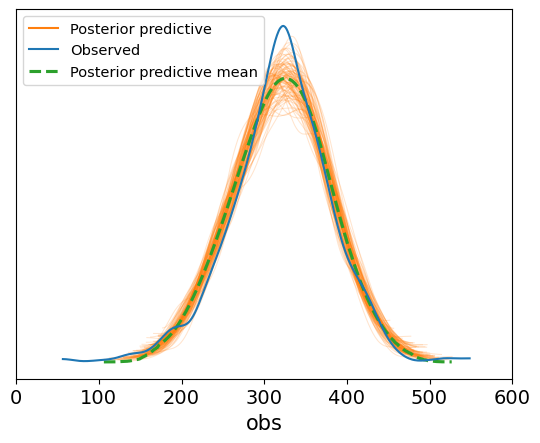

In [10]:
pm.sample_posterior_predictive(idataN1,modelN1, extend_inferencedata=True)
ax = az.plot_ppc(idataN1, num_pp_samples=100, colors=["C1", "C0", "C2"])
ax.set_xlim(0, 600)

This PPC looks very similar to the previous ones in Model 1 & 2 probably because the likelihood is the same. I think the more interesting stuff will occur in the PDP, VI, and ICE plots. 

<Axes: ylabel='R²'>

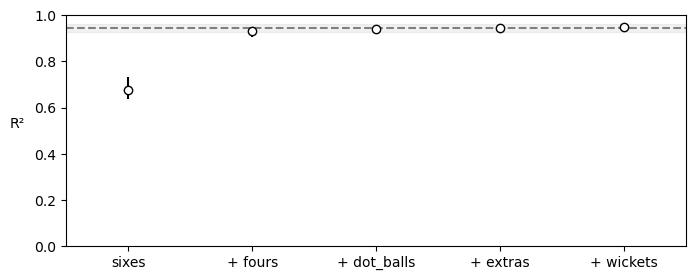

In [13]:
viN1 = pmb.compute_variable_importance(idataN1, μ_, X)
pmb.plot_variable_importance(viN1)

From this we can clearly see sixes is the most important predictor while the others are all the others are super far behind. This makes sense to me because sixes give the most runs so they will contribute the most to the prediction. 

In [12]:
posterior_mean = idataN1.posterior["μ"]

μ_hdi = az.hdi(ary=idataN1, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idataN1, group="posterior_predictive", var_names=["obs"]
).T

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


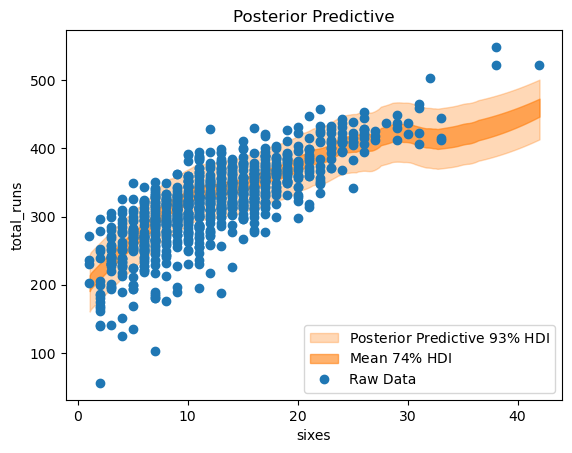

In [51]:
X_numeric = X.values

idx = np.argsort(X_numeric[:, 1])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X_numeric[:, 1],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X_numeric[:, 1],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(X['sixes'], matches["total_runs"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="sixes",
    ylabel="total_runs",
);

We can clearly see that it fits the data really well and looks good which again makes sense as sixes directly effect the total runs. I think I want to look at a pairplot to see the trends with the other variables then look at the PDP and ICE plots. 

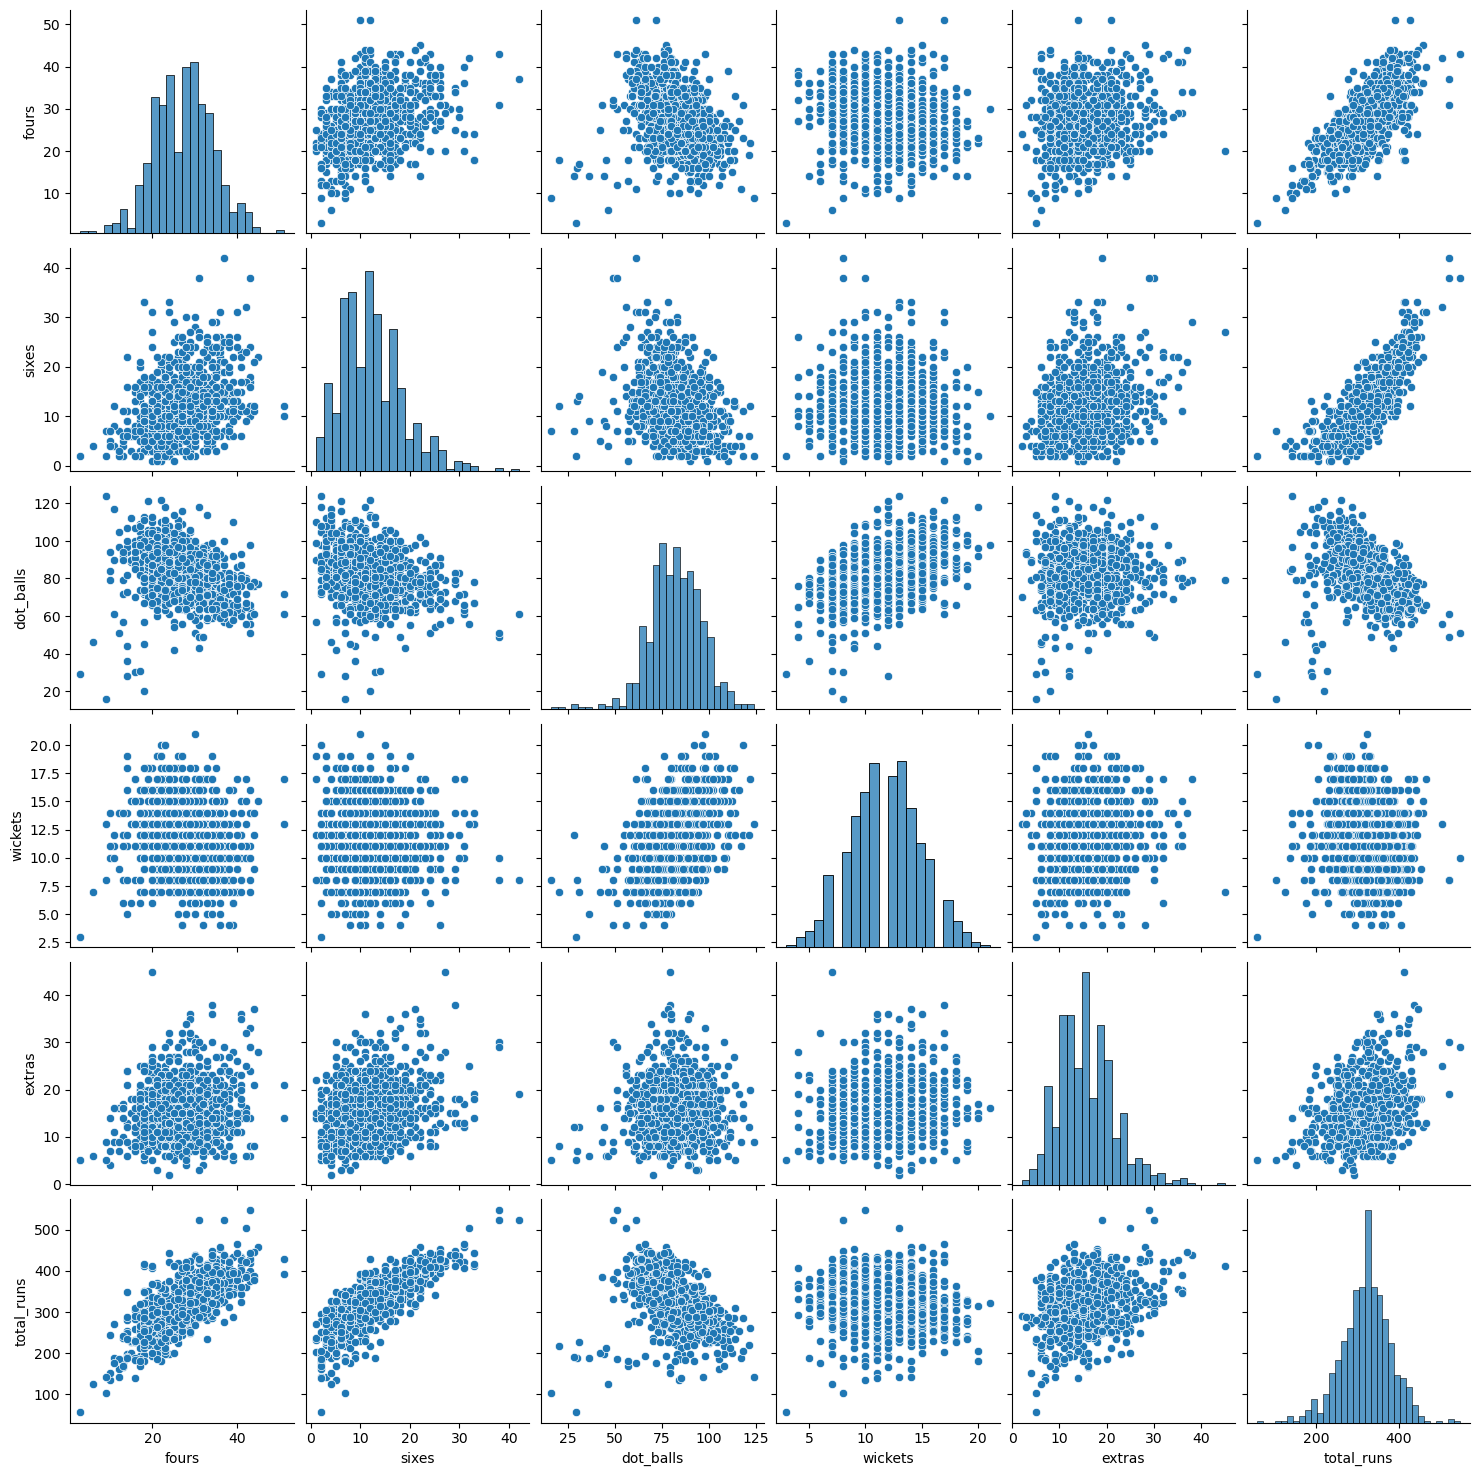

In [50]:
sns.pairplot(pd.concat([X.reset_index(drop=True), matches["total_runs"].reset_index(drop=True)], axis=1))

from this pair plot, we can see trends that match my priors about cricket. First, both fours and sixes show a strong positive relationship with total_runs as a team hits more boundaries, the total score naturally goes up. While, there is a clear negative trned between dot_balls and total_runs, meaning that more balls with no runs tend to result in a lower match total again intrinsiclly making sense. The wickets variable shows no correlation from what I can tell, which is very suprising to me as I thought there would be a negative correlation. The extras display a positive, though more scattered, trend with total runs. Again making sense as getting extra runs from wides or no-balls can increase a team’s total, but it’s generally a smaller effect compared to boundaries. 






array([<Axes: xlabel='fours'>, <Axes: xlabel='sixes'>,
       <Axes: xlabel='dot_balls'>, <Axes: xlabel='wickets'>,
       <Axes: xlabel='extras'>], dtype=object)

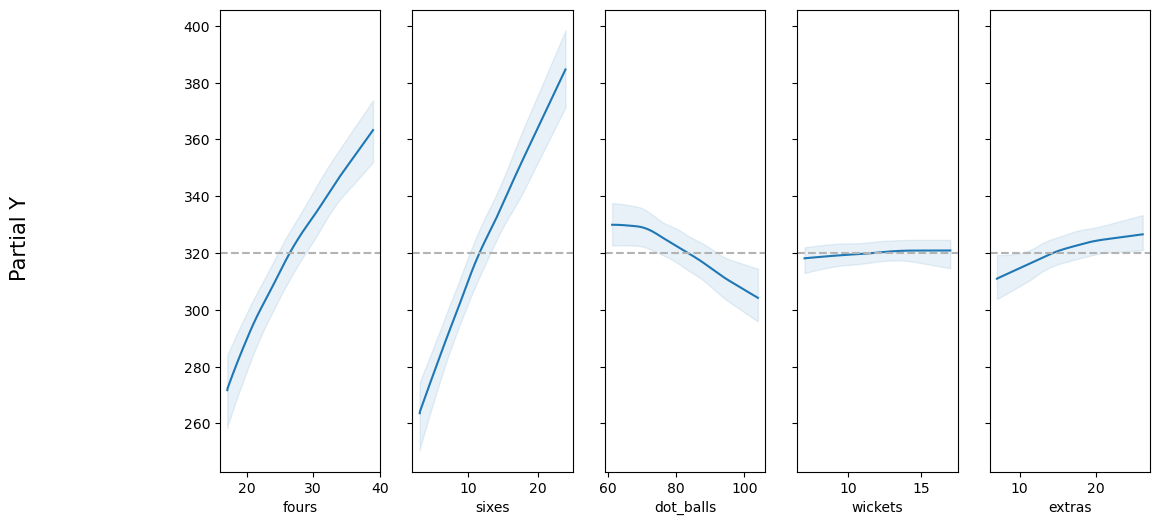

In [53]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

The partial dependence plots for this model are similar to the pairplot findings. Sixes clearly have the steepest positive slope, confirming that the number of sixes is the strongest driver of total runs (more sixes raise the predicted total). Fours also show a significant positive effect, the PDP line rises markedly with more fours, even though fours were ranked a bit lower in the VI plot. This indicates that hitting more fours does boost total runs, but fours’ importance may have been understated in the VI plot as teams that hit many sixes often hit fours as well (will check the ICE plot). Dot balls show a negative slope as the count of dot balls increases, the expected total runs drops. This makes cricket sense since 4's and 6's directly add to the score, whereas dot balls waste scoring opportunities. In summary, the PDPs shows sixes, fours, and dot balls as having the biggest effects on a match’s total runs.

array([<Axes: xlabel='fours'>, <Axes: xlabel='sixes'>,
       <Axes: xlabel='dot_balls'>, <Axes: xlabel='wickets'>,
       <Axes: xlabel='extras'>], dtype=object)

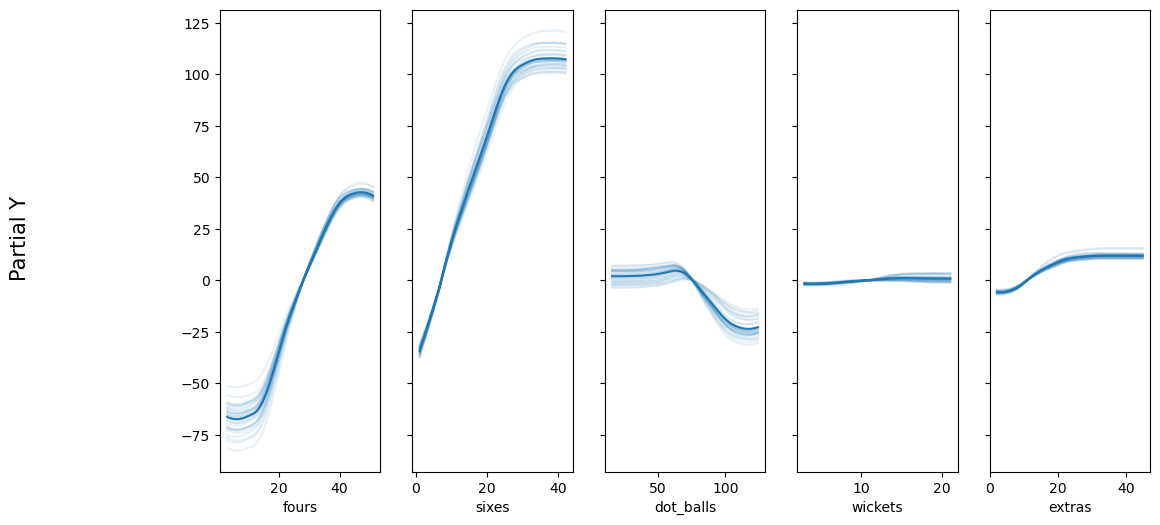

In [54]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), figsize = (12,6))

ICE plots show that for fours, sixes, and dot balls, the lines are almost parallel. This implies there is little to no interaction between these predictors. In general, the model does not appear to have any strong interactions among the numeric variables, which aligns with my prior. One interesting observation is with extras, we initially suspected extras might interact with other factors (perhaps high-scoring games also see more extras), but the ICE lines for extras are also relatively parallel.

In summary, this model indicates that sixes, fours, and dot balls are the most important predictors of a match’s total runs, with sixes and fours being the strongest ones. High totals are primarily driven by hitting more boundaries (especially sixes, and to a lesser extent fours) and by minimizing the number of dot balls. These three features stood out consistently across the analyses, whereas wickets taken and extras conceded played a much smaller role than I expected. The takeaway is that how effectively a team scores off each ball is the dominant factor in determining their final run total.

## Model 2

Now in this model I want to see how using only sixes and fours looks as they are the strongest predictors. I am also going to try out the student t distribution as from the previous dummy section that performed slightly better. I will also create one more model with only the strongest predictors of sixes and seasons from the dummies section. 

In [97]:
X = matches[['sixes', "fours"]]
Y = matches['total_runs'].values

with pm.Model() as modelN2:
    σ = pm.HalfNormal('σ', 10)
    ν = pm.Exponential('ν', 0.1)        
    μ_ = pmb.BART('μ_', X.values, Y, m=50)
    μ  = pm.Deterministic('μ', μ_)
    obs = pm.StudentT('obs', mu=μ, sigma=σ, nu=ν, observed=Y)
    idataN2 = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, ν]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


Sampling: [obs]


Output()

(0.0, 600.0)

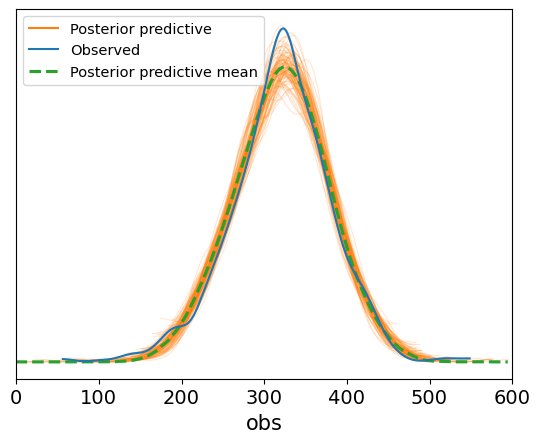

In [98]:
pm.sample_posterior_predictive(idataN2,modelN2, extend_inferencedata=True)
ax = az.plot_ppc(idataN2, num_pp_samples=100, colors=["C1", "C0", "C2"])
ax.set_xlim(0, 600)

Our PPC looks slightly better than before and this plot shows again it matches the data well. This goes to show how strong of a predictor sixes and four really are, it could also be part that we changed our distribution to Student T which improved the PPC. 

In [92]:
posterior_mean = idataN2.posterior["μ"]

μ_hdi = az.hdi(ary=idataN2, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idataN2, group="posterior_predictive", var_names=["obs"]
).T

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


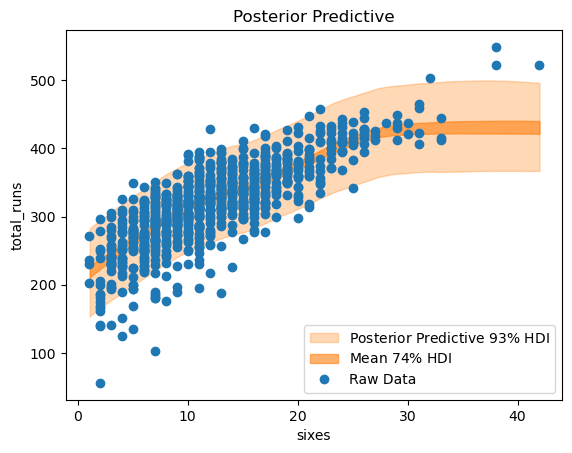

In [99]:
X_numeric = X.values

idx = np.argsort(X_numeric[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X_numeric[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X_numeric[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(X['sixes'], matches["total_runs"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="sixes",
    ylabel="total_runs",
);

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


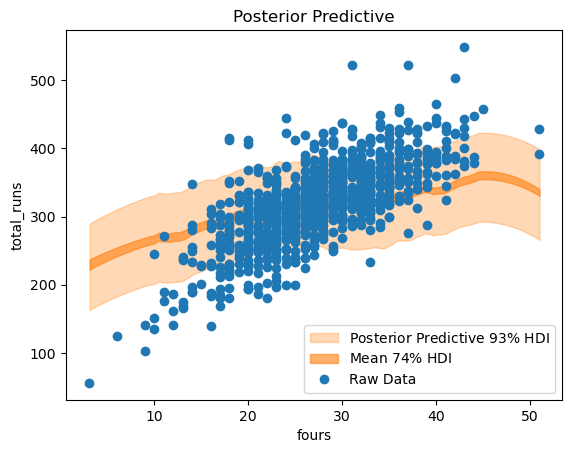

In [100]:
X_numeric = X.values

idx = np.argsort(X_numeric[:, 1])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X_numeric[:, 1],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X_numeric[:, 1],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(X['fours'], matches["total_runs"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="fours",
    ylabel="total_runs",
);

Both our plots for sixes and fours fit the data well, sixes more that fours. 

<Axes: ylabel='R²'>

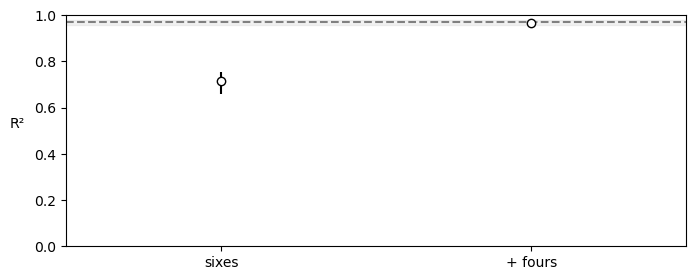

In [101]:
viN2 = pmb.compute_variable_importance(idataN2, μ_, X)
pmb.plot_variable_importance(viN2)

Our VI shows that sixes is overwhelmingly the better predictor and I think a combination of sixes and fours create a really strong model. 

## Model 3 FINALLY ITS OVER!!!

For this final model I want to combine the insights from the dummies section and the numbers section to create one final model using only sixes and seasons.

In [105]:
sixes = deliveries.groupby('match_id')['batsman_runs'].apply(lambda x: (x == 6).sum()).reset_index(name='sixes')
fours = deliveries.groupby('match_id')['batsman_runs'].apply(lambda x: (x == 4).sum()).reset_index(name='fours')
runs = pd.merge(sixes, fours, on='match_id', how='outer')

X = matches[['id', 'season']].merge(runs, left_on='id', right_on='match_id', how='left')
X = X[['season', 'sixes', 'fours']]
X['season'] = X['season'].apply(lambda s: int(s.split('/')[0]) if isinstance(s, str) else s)

X

,season,sixes,fours
0,2011,7,28
1,2011,8,25
2,2011,12,25
3,2011,3,17
4,2011,5,26
...,...,...,...
915,2024,26,31
916,2024,16,29
917,2024,13,33
918,2024,14,24


In [106]:
with pm.Model() as modelN3:
    σ = pm.HalfNormal('σ', 10)
    ν = pm.Exponential('ν', 0.1)        
    μ_ = pmb.BART('μ_', X.values, Y, m=50)
    μ  = pm.Deterministic('μ', μ_)
    obs = pm.StudentT('obs', mu=μ, sigma=σ, nu=ν, observed=Y)
    idataN3 = pm.sample(compute_convergence_checks=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ, ν]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.


Sampling: [obs]


Output()

(0.0, 600.0)

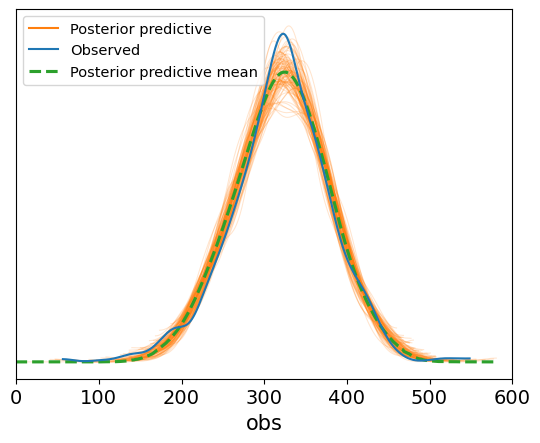

In [107]:
pm.sample_posterior_predictive(idataN3,modelN3, extend_inferencedata=True)
ax = az.plot_ppc(idataN3, num_pp_samples=100, colors=["C1", "C0", "C2"])
ax.set_xlim(0, 600)

After building a model that combined season with sixes and fours, we can see that its PPC was virtually identical to the model using only sixes and fours. In other words, adding the season factor did not improve the predictions, suggesting that sixes (and fours) carry far more predictive weight than the season does. Previously, season emerged as a dominant variable in the all-dummy model, but that was likely because it was one of the only informative signals among many weak variables. This shows that season by itself isn’t nearly as impactful for predicting runs as the numerical metrics. Season may have seemed important in the context of a weak set of predictors, but it turns out to add little value alongside stronger predictors.

In [108]:
posterior_mean = idataN1.posterior["μ"]

μ_hdi = az.hdi(ary=idataN2, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idataN2, group="posterior_predictive", var_names=["obs"]
).T

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


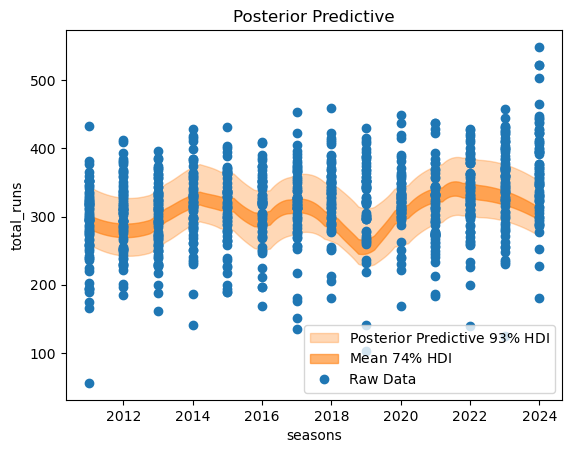

In [109]:
X_numeric = X.values

idx = np.argsort(X_numeric[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X_numeric[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X_numeric[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(X['season'], matches["total_runs"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="seasons",
    ylabel="total_runs",
);

Season cannot capture the large variability in match totals. Within any given year, total runs fluctuate widely from match to match. The model’s fit using season essentially tracks the average run outcome per year and misses the actual variability ie it cannot reach the actual high and low extremes seen in the data for each season. This shows that season is a weak predictor of a single match’s runs. It might reflect a general trend (like a gradual increase in scoring over the years). The model can match the overall average per season fairly well, but it doesn't predict the spread of scores within each season.

<Axes: ylabel='R²'>

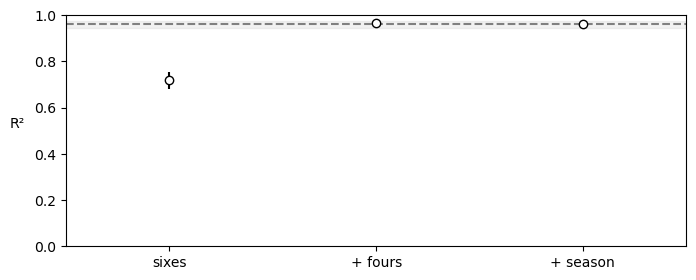

In [110]:
viN3 = pmb.compute_variable_importance(idataN3, μ_, X)
pmb.plot_variable_importance(viN3)

From this vi plot it is clear that sixes & fours are the variables that contribute the most to predicitng total runs with sixes contributing most of the R^2 score.

array([<Axes: xlabel='season'>, <Axes: xlabel='sixes'>,
       <Axes: xlabel='fours'>], dtype=object)

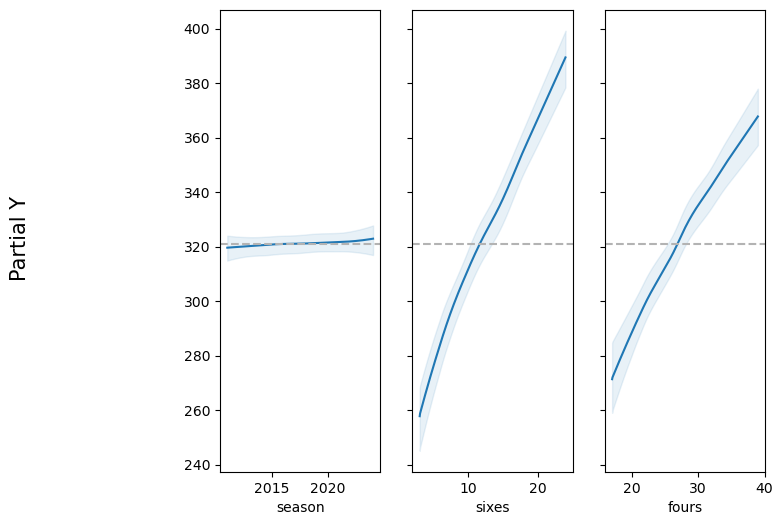

In [111]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), figsize = (12,6))

Again PDP confirms this as sixes and fours have an overwhelming positive slope compared to seasons flat slope. 

array([<Axes: xlabel='season'>, <Axes: xlabel='sixes'>,
       <Axes: xlabel='fours'>], dtype=object)

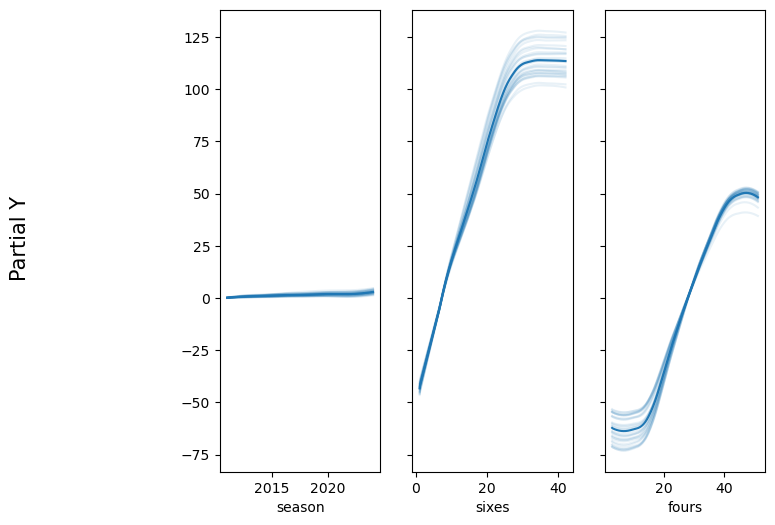

In [112]:
pmb.plot_ice(μ_, X, Y, grid=(1, 5), figsize=(12, 6))

Again for this ICE plot the lines are parallel showing no interaction betwen predictors. Season is also shown to have a very small slope showing that it really isn't a good predictor. 

These models, predicted by in-game statistics paint a much clearer picture of what gives big totals. As expected in cricket logic, teams that hit more boundaries (especially sixes, and also fours) tend to get significantly higher scores, and teams that consume more dot balls (deliveries with no runs) see their totals suffer. These numerical features sixes, fours, and dot balls stood out as the key predictors of match total runs with sixes being the most important and dot_balls the least but still significant. Other numerical factors like wickets lost and extras conceded had surprisingly little impact on the predictive model. This makes sense as while losing wickets can slow a team down, it’s not a direct source of runs (and teams can sometimes score high despite losing wickets, or score less with wickets in hand), and extra runs from no-balls or wides aren't a large enough amount to make a significant difference. In short, this analysis confirms that it’s the scoring efficiency. maximizing boundaries and minimizing wasted balls, that largely determines how many runs a team puts up in a T20 match.


# Final Conclusion

Across the project, a clear theme is seen. What happens on the field matters far more than the game’s setting or circumstances. The dummy-variable models provided some context such as showing that IPL scores have trended increasing over the years. But these factors alone were weak predictors of a single match’s total runs. In contrast, the number model using match statistics captured runs directly and then became a stronger model. Combining the best predictors from both approaches confirmed these findings. Once the numeric predictors were used, adding other variables like season did little to improve accuracy. For practical purposes, this means that if we want to predict or explain total runs in a cricket match, we should focus on the team’s batting performance metrics rather than external conditions. Factors such as how aggressively the team scores (boundaries hit) and how efficiently they use their overs (minimizing dot balls) are the best predictors for big totals, whereas things like toss decisions or stadium are only minor influences. I think it was really interesting seeing how all of these variables effected each other and gave me some new insight into cricket overall as I initally thought match type and the team you're playing against would have a big effect but it doesn't really. I think this goes to show that the IPL is getting better overall and the barrier between teams is shrinking as the total runs is increasing with time and the team you're against matters less and less. 

